In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('C://work/dev/python/progs/texts/sec_bert/')

In [3]:

import pandas as pd
import numpy as np
import joblib

from ruamel.yaml import YAML

conf = YAML().load(open('params.yaml'))

np.random.seed(conf['seed'])

# Close mappings

## execution

In [41]:
df = pd.read_csv(conf['get_data']['data_fn'])
df.head(2)

,sentence,labels,url,par_name,origin_labels
0,Adversaries may inject malicious code into pro...,"['defense-evasion', 'privilege-escalation']",https://attack.mitre.org/techniques/T1055/011,Process Injection,['T1055.011']
1,Adversaries may abuse the Windows Task Schedul...,"['execution', 'persistence', 'privilege-escala...",https://attack.mitre.org/techniques/T1053/005,Scheduled Task/Job,['T1053.005']


In [45]:
df['labels'] = df['labels'].map(lambda x: eval(x))
df['origin_labels'] = df['origin_labels'].map(lambda x: eval(x))

In [46]:
tech_l = ['T1218', 'T1480', 'T1202', 'T1216', 'T1127']


In [48]:
sel = (df['par_name'].fillna('').str.contains('Execution')) & \
(df['origin_labels'].astype(str).map(lambda x: len([it for it in tech_l if it in x])>0))

df.loc[sel, 'labels'] = df.loc[sel, 'labels'].map(lambda x: x + ['execution'])

# Research

In [4]:

mitre_attack = pd.read_csv(conf['get_data']['data_mitre_attack_proc_fn'])
mitre_attack

,sentence,labels,url
0,Adversaries may inject malicious code into pro...,T1055.011,https://attack.mitre.org/techniques/T1055/011
1,Adversaries may abuse the Windows Task Schedul...,T1053.005,https://attack.mitre.org/techniques/T1053/005
2,Adversaries may attach filters to a network so...,T1205.002,https://attack.mitre.org/techniques/T1205/002
3,Adversaries may use utilities to compress and/...,T1560.001,https://attack.mitre.org/techniques/T1560/001
4,Adversaries may use [Valid Accounts] to remote...,T1021.005,https://attack.mitre.org/techniques/T1021/005
...,...,...,...
14353,[DustySky] can shutdown the infected machine.(...,T1529,https://attack.mitre.org/techniques/T1529
14354,[Cobalt Strike] can use spoof arguments in spa...,T1564.010,https://attack.mitre.org/techniques/T1564/010
14355,[SombRAT] has the ability to modify its proces...,T1564.010,https://attack.mitre.org/techniques/T1564/010
14356,[Blue Mockingbird] has used wmic.exe and Windo...,T1574.012,https://attack.mitre.org/techniques/T1574/012


In [109]:
sent = 'find / -perm'

with pd.option_context('display.max_colwidth', 2000):

    display(mitre_attack[mitre_attack.sentence.str.contains(sent)])




,sentence,labels,url
275,"An adversary may abuse configurations where an application has the setuid or setgid bits set in order to get code running in a different (and possibly more privileged) user’s context. On Linux or macOS, when the setuid or setgid bits are set for an application binary, the application will run with the privileges of the owning user or group respectively.(Citation: setuid man page) Normally an application is run in the current user’s context, regardless of which user or group owns the application. However, there are instances where programs need to be executed in an elevated context to function properly, but the user running them may not have the specific required privileges.\n\nInstead of creating an entry in the sudoers file, which must be done by root, any user can specify the setuid or setgid flag to be set for their own applications (i.e. [Linux and Mac File and Directory Permissions Modification]. The <code>chmod</code> command can set these bits with bitmasking, <code>chmod 4777 [file]</code> or via shorthand naming, <code>chmod u+s [file]</code>. This will enable the setuid bit. To enable the setgid bit, <code>chmod 2775</code> and <code>chmod g+s</code> can be used.\n\nAdversaries can use this mechanism on their own malware to make sure they're able to execute in elevated contexts in the future.(Citation: OSX Keydnap malware) This abuse is often part of a ""shell escape"" or other actions to bypass an execution environment with restricted permissions.\n\nAlternatively, adversaries may choose to find and target vulnerable binaries with the setuid or setgid bits already enabled (i.e. [File and Directory Discovery]. The setuid and setguid bits are indicated with an ""s"" instead of an ""x"" when viewing a file's attributes via <code>ls -l</code>. The <code>find</code> command can also be used to search for such files. For example, <code>find / -perm +4000 2>/dev/null</code> can be used to find files with setuid set and <code>find / -perm +2000 2>/dev/null</code> m...",T1548.001,https://attack.mitre.org/techniques/T1548/001


In [4]:
feat_data = pd.read_csv(conf['feat_eng']['feat_final_fn'])
mlb = joblib.load(conf['prep_text']['mlb_fn'])
data = pd.read_csv(conf['feat_gen']['data_fn'])
data = data.assign(sentence=lambda x: x['sentence'].str.replace('\n', ''))

data['target'] = data['target'].map(lambda x: eval(x))

data['labels'] = data['labels'].map(lambda x: frozenset(eval(x)))

label2tactic = joblib.load('data/label2tactic.pkl')

# Косинусное сходство для tf/idf и стемминга

In [5]:
from sklearn.metrics.pairwise import cosine_distances

matr_dist = cosine_distances(feat_data, feat_data)

In [6]:
# взять индексы i < j
thresh = 0.1
dist_df = pd.DataFrame(matr_dist)

In [7]:
select_df = dist_df.stack().loc[lambda x: (x!=0) & (x<thresh)]

In [8]:
pairs = select_df.index.tolist()

# убрали дубли
pairs = [(it1, it2) for it1, it2 in pairs if it1<it2]

In [9]:
comp_df = data.loc[data.index[[it1 for it1, _ in pairs]], ['sentence', 'labels', 'url']].reset_index(drop=True).join(
    data.loc[data.index[[it2 for _, it2 in pairs]], ['sentence', 'labels', 'url']].reset_index(drop=True), 
    lsuffix='_left', rsuffix='_right'
)

In [10]:
cond = comp_df.apply(lambda x: x['labels_left']!=x['labels_right'], axis=1) 
# тут сравниваются множества (преобразовал сверху), 
# не сравнивал списки, так как в 54 случаях элементы местами поменены, например, comp_df.loc[20845]
comp_df = comp_df[cond]


## Изучаем разницу

In [11]:
# исключаем случай большой длины
comp_df = comp_df.assign(len_left=lambda x: x['sentence_left'].str.len())\
        .assign(len_right=lambda x: x['sentence_right'].str.len())\
        .query('len_left < 200 and len_right<200')
        

In [12]:
comp_df.to_csv('data/out/close_texts.csv', sep=';', index=False)

In [13]:
comp_df.iloc[12]
#.query('sentence_left.str.contains("AsyncRAT")')

sentence_left     [JHUHUGIT] has registered itself as a schedule...
labels_left          (persistence, execution, privilege-escalation)
url_left              https://attack.mitre.org/techniques/T1053/005
sentence_right    [AsyncRAT] can hide the execution of scheduled...
labels_right                                      (defense-evasion)
url_right             https://attack.mitre.org/techniques/T1564/003
len_left                                                        158
len_right                                                       129
Name: 677, dtype: object

In [14]:
# действительно очень похожие тексты
with pd.option_context('display.max_colwidth', 200):
    display(comp_df.sample(3))

,sentence_left,labels_left,url_left,sentence_right,labels_right,url_right,len_left,len_right
10177,[HermeticWizard] has been signed by valid certificates assigned to Hermetica Digital.(Citation: ESET Hermetic Wizard March 2022),(defense-evasion),https://attack.mitre.org/techniques/T1553/002,[EvilBunny] has been observed querying installed antivirus software.(Citation: Cyphort EvilBunny Dec 2014),(discovery),https://attack.mitre.org/techniques/T1518/001,128,106
13682,[ZIRCONIUM] has purchased domains for use in targeted campaigns.(Citation: Microsoft Targeting Elections September 2020),(resource-development),https://attack.mitre.org/techniques/T1583/001,[APT28] has harvested user's login credentials.(Citation: Microsoft Targeting Elections September 2020),(reconnaissance),https://attack.mitre.org/techniques/T1589/001,120,103
16599,[MegaCortex] can parse the available drives and directories to determine which files to encrypt.(Citation: IBM MegaCortex),(discovery),https://attack.mitre.org/techniques/T1083,[DEATHRANSOM] can use public and private key pair encryption to encrypt files for ransom payment.(Citation: FireEye FiveHands April 2021),(impact),https://attack.mitre.org/techniques/T1486,123,137


In [15]:
# пары отличий
freq_ser = comp_df[['labels_left', 'labels_right']].value_counts()[:30]

In [16]:
from collections import defaultdict
cls_d = defaultdict(list)
for cls in mlb.classes:
    ind = freq_ser.index.map(lambda x: list(x[0])+ list(x[1])).map(lambda x: cls in x)
    names_ser = pd.Series(freq_ser[ind].index.map(lambda x: [it for it in list(x[0])+ list(x[1]) if it!=cls]).tolist())
    
    other_cls_df = pd.DataFrame({'names':names_ser, 'freq':freq_ser[ind].reset_index(drop=True)})\
    .assign(names = lambda x: x['names'].map(lambda x: frozenset(x)))\
    .groupby('names', as_index=False)['freq'].sum()
    cls_d[cls] = [other_cls_df['freq'].sum(), other_cls_df]

In [17]:
pd.DataFrame([(k, v[0]) for k, v in cls_d.items()], columns=['cls', 'val']).sort_values(by='val', ascending=False)

,cls,val
0,defense-evasion,2263
2,execution,1491
4,command-and-control,1397
8,discovery,842
11,impact,620
5,collection,481
1,privilege-escalation,322
3,persistence,322
9,resource-development,209
12,initial-access,60


In [18]:
cls_d['defense-evasion']

[2263,
                                             names  freq
 0                                     (execution)   766
 1                           (command-and-control)   561
 2                                        (impact)   370
 3                                     (discovery)   297
 4             (persistence, privilege-escalation)   121
 5  (persistence, execution, privilege-escalation)    85
 6                                    (collection)    63]

### Выводы
- где-то 1/3 из-за путаница из-за присутствия в одном из случаев длинных описаний текстов
- основное пересечение по текстам - это defence-evasion, больше всего с execution


In [ ]:
- Citation: SecureWorks August 2019 
- тактики defense-evasion техники T1218, T1480, T1202, T1216, T1127 и всех их подтехники можно допустить ошибку и принудительно отнести в сторону Execution
- Command and Control T1665, T1001, T1205 и всех их подтехники можно допустить ошибку и принудительно отнести в сторону defense-evasion

# Кластеризация

In [111]:
# действительно очень похожие тексты
with pd.option_context('display.max_colwidth', 200):

    display(data[data.sentence.str.contains('Mafalda')])



,sentence,labels,url,prep_text,target,split,threat_words
1078,[Mafalda] can take a screenshot of the target machine and save it to a file.(Citation: SentinelLabs Metador Sept 2022),(collection),https://attack.mitre.org/techniques/T1113,mafalda can take screenshot the target machin and save file citat metador sept 2022,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",tr,[]
1327,[Mafalda] can collect the username from a compromised host.(Citation: SentinelLabs Metador Technical Appendix Sept 2022),(discovery),https://attack.mitre.org/techniques/T1033,mafalda can collect the usernam from host citat metador technic appendix sept 2022,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",tr,[]
1511,[Mafalda] can encode data using Base64 prior to exfiltration.(Citation: SentinelLabs Metador Technical Appendix Sept 2022),(command-and-control),https://attack.mitre.org/techniques/T1132/001,mafalda can encod data use base64 prior citat metador technic appendix sept 2022,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",tr,[]
1992,[Mafalda] has been obfuscated and contains encrypted functions.(Citation: SentinelLabs Metador Sept 2022),(defense-evasion),https://attack.mitre.org/techniques/T1027/013,mafalda has been obfusc and contain encrypt function citat metador sept 2022,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",tr,[]
2134,[Mafalda] can establish an SSH connection from a compromised host to a server.(Citation: SentinelLabs Metador Technical Appendix Sept 2022),"(initial-access, persistence)",https://attack.mitre.org/techniques/T1133,mafalda can establish ssh connect from host server citat metador technic appendix sept 2022,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",tr,[]
2516,[Mafalda] can place retrieved files into a destination directory.(Citation: SentinelLabs Metador Sept 2022),(collection),https://attack.mitre.org/techniques/T1074/001,mafalda can place retriev file into directori citat metador sept 2022,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",ts,[]
3260,[Mafalda] can encrypt its C2 traffic with RC4.(Citation: SentinelLabs Metador Sept 2022),(command-and-control),https://attack.mitre.org/techniques/T1573/001,mafalda can encrypt it traffic with rc4 citat metador sept 2022,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",val,[]
4562,[Mafalda] can collect the computer name and enumerate all drives on a compromised host.(Citation: SentinelLabs Metador Sept 2022)(Citation: SentinelLabs Metador Technical Appendix Sept 2022),(discovery),https://attack.mitre.org/techniques/T1082,mafalda can collect the comput name and enumer all drive host citat metador sept 2022 citat metador technic appendix sept 2022,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",tr,[]
4930,[Mafalda] can use a variety of API calls.(Citation: SentinelLabs Metador Sept 2022),(execution),https://attack.mitre.org/techniques/T1106,mafalda can use varieti api call citat metador sept 2022,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",tr,[]
5062,[Mafalda] can collect files and information from a compromised host.(Citation: SentinelLabs Metador Sept 2022),(collection),https://attack.mitre.org/techniques/T1005,mafalda can collect file and from host citat metador sept 2022,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",val,[]


## DBSCAN

In [ ]:
cl_data = data.explode('labels').reset_index(drop=True)

cl_feat_data = feat_data.assign(labels=data['labels']).explode('labels')\
                .reset_index(drop=True).drop(columns='labels')

In [87]:
from sklearn.neighbors import NearestNeighbors

min_samples=50
model = NearestNeighbors(metric='cosine')
model.fit(cl_feat_data)

NearestNeighbors(metric='cosine')

In [88]:
dists, inds = model.kneighbors(cl_feat_data)

In [89]:
dists_ar = dists[:, 1:min_samples].mean(axis=1)
dists_ar.sort()

<Axes: >

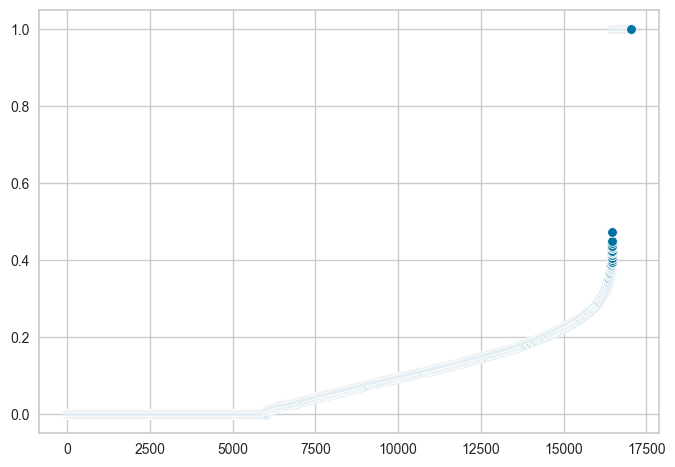

In [90]:
import seaborn as sns

sns.scatterplot(x=range(len(dists_ar)), y=dists_ar)

In [91]:
from sklearn.cluster import DBSCAN

eps = np.quantile(dists_ar, 0.95)
clust = DBSCAN(n_jobs=-1, min_samples=min_samples, eps=eps, metric='cosine')
clust.fit(cl_feat_data)

DBSCAN(eps=0.3094613049253897, metric='cosine', min_samples=50, n_jobs=-1)

In [92]:
(clust.labels_==-1).sum()

2210

In [93]:
np.unique(clust.labels_)

array([-1,  0,  1,  2,  3,  4,  5], dtype=int64)

In [96]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=1, early_exaggeration=2000, n_jobs=-1, random_state=conf['seed'])
X = tsne.fit_transform(cl_feat_data)

<Axes: >

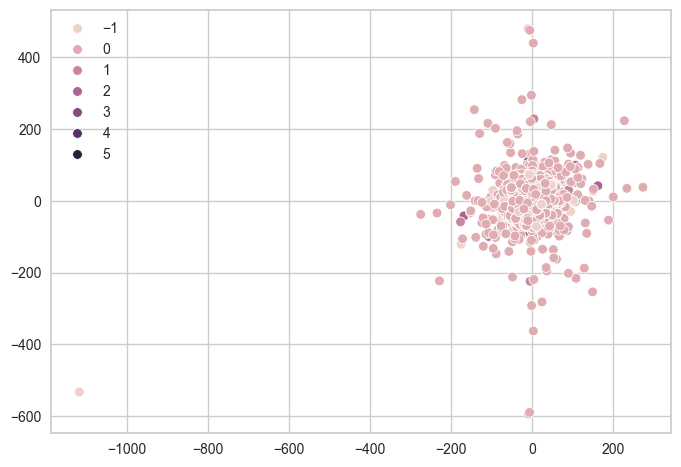

In [98]:
sns.scatterplot(x=X[:,0], y=X[:,1], hue=clust.labels_)

C:\tools\Anaconda3\envs\pytorch_env\lib\site-packages\yellowbrick\text\tsne.py:401: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  self.ax.scatter(


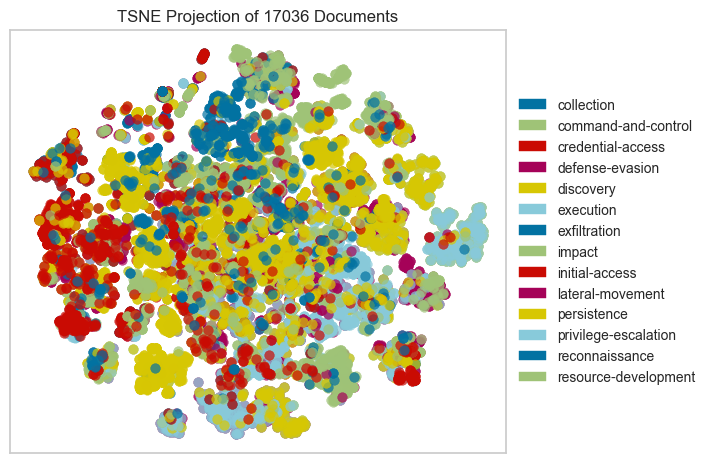

<Axes: title={'center': 'TSNE Projection of 17036 Documents'}>

In [74]:
from yellowbrick.text import TSNEVisualizer

tsne = TSNEVisualizer(decompode_by=10)
tsne.fit(cl_feat_data, cl_data['labels'], alpha=0.2)
tsne.poof()

# Вопросы
- есть ли secure sentence embeddings?